# Relevance demo

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import time
from typing import Optional

import pandas as pd
import numpy as np

from google import genai
from google.genai import types

from config import LLM_CONFIG
from utils import get_key

In [3]:

PERSONA_FILES = {
    "sonia" :"../data/bme_persona_sonia.md",
    "liz": "../data/bme_persona_liz.md",
}
SELECTED_USER_STORY = "../data/bme_us1.md"

cq_df = pd.read_csv("../data/bme_cq_measures.csv")

persona_descriptions = {}

for persona_name, persona_file in PERSONA_FILES.items():
    with open(persona_file, "r") as f:
        persona_descriptions[persona_name] = f.read()
        
# Read the selected user story
with open(SELECTED_USER_STORY, "r") as f:
    user_story = f.read()

In [4]:

from pydantic import BaseModel, Field
from typing import Literal

class CQRelevanceRating(BaseModel):
    score: Literal["1", "2", "3", "4"] = Field(
        description="The relevance rating score from 1 to 4."
    )
    rationale: str = Field(
        description="A brief explanation of the reasoning behind the score."
    )

    def to_dict(self):
        return {
            "score": self.score,
            "rationale": self.rationale
        }
    def __str__(self):
        return f"Score: {self.score}, Rationale: {self.rationale}"


In [17]:
MODEL = "gemini-1.5-pro"
MODEL = "gemini-2.5-pro-preview-03-25"
KEY = get_key("gemini")

client = genai.Client(api_key=KEY)

## Relevance extraction

### CQ examples

In [18]:

test_cq_a = "Which events are associated to a given item?" # expected high relevance
test_cq_b = "To which specific period or era does this item belong?" # expected high relevance

test_cq_c = "What is the alias of a music artist?" # expected mid relevance
test_cq_d = "Who is the composer of a music work?" # expected mid relevance

test_cq_e = "Are there any copyright restrictions on the multimedia files?" # expected domain/context/persona relevance
test_cq_f = "What are the specific humidity requirements for the item?" # expected domain/context/persona relevance

test_cq_g = "How was the item acquired by the museum?" # expected lowest relevance
test_cq_h = "Where can an item be sent for repairs?" # expected lowest relevance

# all in a list
test_cqs = [
    test_cq_a,
    test_cq_b,
    test_cq_c,
    test_cq_d,
    test_cq_e,
    test_cq_f,
    test_cq_g,
    test_cq_h
]

### Prompting strategy A: CQ +user story

In [27]:
from prompts import SYSTEM_ROLE_RELEVANCE_A, SYSTEM_ROLE_RELEVANCE_P
from prompts import PROMPT_RELEVANCE_A, PROMPT_RELEVANCE_B, PROMPT_RELEVANCE_C

full_persona_description = "\n".join(persona_descriptions.values())
prompt = PROMPT_RELEVANCE_A.format(
    user_story=user_story,
    persona_description=full_persona_description,
    cq=cq_df["cq"].values[0],
)

print(prompt)


Rate the relevance of the given competency question with respect to the given user story using a Likert scale from 1 to 4, where:
1 = The competency question introduces an extra requirement that is not expressed in the user story and cannot be inferred at all (non-necessary requirement);
2 = The competency question cannot be inferred from the user story (even using common sense or domain knowledge) but is still an enabler for the requirements expressed in the user story;
3 = The competency question addresses a requirement that can be inferred from the user story using common sense and domain knowledge;
4 = The competency question addresses a requirement that is explicitly expressed in the user story.

**Competency Question:**
"Are there images of the item being used or created by the artist?"

**User Story:**
"# (S1) Sharing Iconic Treasures: Knowledge Exchange and Metadata Generation

### Personas
- Sonia (donor)
- Liz (manager)

### Priority
High

### Goal
**Keywords:** loan agreeme

In [ ]:
def relevance_analysis(cq: str,
                       user_story:str,
                       persona_descriptions: Optional[dict] = None,
                       system_role: Optional[str] = SYSTEM_ROLE_RELEVANCE_A,
                       prompt_template: Optional[str] = PROMPT_RELEVANCE_A,
                       model: Optional[str] = "gemini-2.5-pro-preview-03-25") -> dict:
    """
    Function to analyze the relevance of a user story to a given persona.
    
    Args:
        cq (str): The CQ measure to be analyzed.
        user_story (str): The user story to be analyzed, in markdown format.
        persona_descriptions (dict): A dictionary containing persona
            descriptions indexed by persona name and described in markdown.

    Returns:
        dict: A dictionary containing the relevance rating and rationale.

    """
    full_persona_description = "\n".join(persona_descriptions.values())
    prompt = prompt_template.format(
        user_story=user_story,
        persona_description=full_persona_description,
        cq=cq,
    )
    # Prompt using a Gemini model
    response = client.models.generate_content(
        model=model,
        config=types.GenerateContentConfig(
            response_mime_type='application/json',
            response_schema=CQRelevanceRating,
            system_instruction=system_role,
            temperature=LLM_CONFIG["temperature"],
            top_p=LLM_CONFIG["top_p"],
            frequency_penalty=LLM_CONFIG["frequency_penalty"],
            presence_penalty=LLM_CONFIG["presence_penalty"],
            seed=LLM_CONFIG["seed"],
        ),
        contents=prompt,
    )
    # Create a new instance of the CQAnalysis class
    relevance: CQRelevanceRating = response.parsed
    return relevance.to_dict()

In [29]:
from tqdm import tqdm

relevance_dict = {}
for cq in tqdm(test_cqs, desc="Processing CQs"):
    relevance_dict[cq] = relevance_analysis(cq=cq,
                                            user_story=user_story,
                                            persona_descriptions=persona_descriptions,
                                            system_role=SYSTEM_ROLE_RELEVANCE_P,
                                            prompt_template=PROMPT_RELEVANCE_B)
    # add a delay to avoid rate limits
    time.sleep(.5)

relevance_df = pd.DataFrame.from_dict(relevance_dict, orient="index")
relevance_df = relevance_df.reset_index()

relevance_df.columns = ["cq", "relevance_score", "relevance_rationale"]
relevance_df["relevance_score"] = relevance_df["relevance_score"].astype(int)
relevance_df["relevance_rationale"] = relevance_df["relevance_rationale"].astype(str)


Processing CQs: 100%|██████████| 8/8 [03:48<00:00, 28.58s/it]


In [16]:
relevance_df # 1.5 with persona

,cq,relevance_score,relevance_rationale
0,Which events are associated to a given item?,1,The competency question focuses on the events ...
1,To which specific period or era does this item...,4,The user story explicitly mentions the need to...
2,What is the alias of a music artist?,2,The CQ is somewhat relevant to Sonia's persona...
3,Who is the composer of a music work?,3,The user story focuses on the loan of music me...
4,Are there any copyright restrictions on the mu...,3,"While not explicitly stated, it is implied and..."
5,What are the specific humidity requirements fo...,3,"While ""humidity requirements"" are not explicit..."
6,How was the item acquired by the museum?,4,The user story explicitly discusses the proven...
7,Where can an item be sent for repairs?,1,The user story focuses on the process of loani...


In [22]:
relevance_df # this is the one 2.5 with personas

,cq,relevance_score,relevance_rationale
0,Which events are associated to a given item?,4,The user story explicitly includes 'Associated...
1,To which specific period or era does this item...,4,The user story explicitly states that informat...
2,What is the alias of a music artist?,3,The user story explicitly requires capturing '...
3,Who is the composer of a music work?,3,The user story focuses on capturing detailed i...
4,Are there any copyright restrictions on the mu...,3,The user story states that Sonia provides 'mul...
5,What are the specific humidity requirements fo...,4,The user story explicitly states that 'display...
6,How was the item acquired by the museum?,4,The user story explicitly states that when an ...
7,Where can an item be sent for repairs?,3,The user story emphasizes capturing item condi...


In [25]:
relevance_df # this is the one 2.5 with no personas

,cq,relevance_score,relevance_rationale
0,Which events are associated to a given item?,4,The user story explicitly requires the system ...
1,To which specific period or era does this item...,4,The user story explicitly states that the syst...
2,What is the alias of a music artist?,3,"The user story requires capturing ""Associated ..."
3,Who is the composer of a music work?,3,The user story requires the system to capture ...
4,Are there any copyright restrictions on the mu...,3,The user story mentions that Sonia provides 'm...
5,What are the specific humidity requirements fo...,4,The user story explicitly states that 'display...
6,How was the item acquired by the museum?,4,"The user story explicitly states that ""loan ag..."
7,Where can an item be sent for repairs?,3,The user story explicitly mentions that the sy...


In [30]:
relevance_df # this is the one 2.5 with personas and improved prompt

,cq,relevance_score,relevance_rationale
0,Which events are associated to a given item?,4,The user story explicitly includes 'Associated...
1,To which specific period or era does this item...,4,The user story explicitly states that Sonia pr...
2,What is the alias of a music artist?,3,The user story S1 aims to generate metadata to...
3,Who is the composer of a music work?,4,"The user story, through its example data for '..."
4,Are there any copyright restrictions on the mu...,3,The user story states that Sonia provides 'mul...
5,What are the specific humidity requirements fo...,4,"The user story explicitly states that ""display..."
6,How was the item acquired by the museum?,4,The user story explicitly details that Sonia l...
7,Where can an item be sent for repairs?,3,"The user story emphasizes capturing item ""cond..."


In [31]:
# Now we extract the relevance scores and rationales from all the CQs in cq_df
# and add them to the dataframe as new columns: relevance_ge25p_score and relevance_ge25p_rationale

# We will use the relevance_analysis function to do this
relevance_records = []

for index, row in tqdm(cq_df.iterrows(), total=cq_df.shape[0], desc="Processing CQs"):
    cq = row["cq"]
    relevance = relevance_analysis(cq=cq,
                                   user_story=user_story,
                                   persona_descriptions=persona_descriptions,
                                   system_role=SYSTEM_ROLE_RELEVANCE_A,
                                   prompt_template=PROMPT_RELEVANCE_A)
    relevance_records.append({
        "cq": cq,
        "relevance_score": relevance["score"],
        "relevance_rationale": relevance["rationale"]
    })
     # add a delay to avoid rate limits
    time.sleep(.5)


Processing CQs: 100%|██████████| 204/204 [1:31:20<00:00, 26.87s/it]


In [32]:
# Create a new dataframe from the relevance records
relevance_df = pd.DataFrame(relevance_records)
relevance_df

,cq,relevance_score,relevance_rationale
0,Are there images of the item being used or cre...,4,The user story explicitly states that Sonia co...
1,When is a loaned item expected to be returned?,4,The user story explicitly states that 'loan ag...
2,Is the artefact out for repair?,3,"The user story emphasizes tracking 'condition,..."
3,What type of artist is Queen?,3,"The user story explicitly states that ""Associa..."
4,What are the types of the artefacts that be di...,4,The user story explicitly mentions that artefa...
...,...,...,...
199,How can the system represent the relationship ...,4,The user story explicitly states that Sonia (t...
200,How can the system represent the status of a l...,4,The user story explicitly states that Sonia sh...
201,What information about loaned artifacts should...,4,The user story explicitly states: 'Sonia is gr...
202,How does the system distinguish between artifa...,4,The user story explicitly details that the sys...


In [33]:
# save the relevance_df to a csv file
relevance_df.to_csv("../data/bme_cq_relevance_ge25p_aa_score.csv", index=False)

In [34]:
# Merge the relevance_df with the original cq_df
cq_df = cq_df.merge(relevance_df, on="cq", how="left")
# Rename the columns
cq_df = cq_df.rename(columns={
    "relevance_score": "relevance_ge25p_score",
    "relevance_rationale": "relevance_ge25p_rationale"
})

In [42]:
merged_df = cq_df[["cq", "set", "relevance_ge25p_score", "relevance_ge25p_rationale"]]
merged_df["relevance_ge25p_score"] = merged_df["relevance_ge25p_score"].astype(int)

/var/folders/q6/phq9pwd56q78175j_yvjz8pc0000gn/T/ipykernel_71413/1516961778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["relevance_ge25p_score"] = merged_df["relevance_ge25p_score"].astype(int)


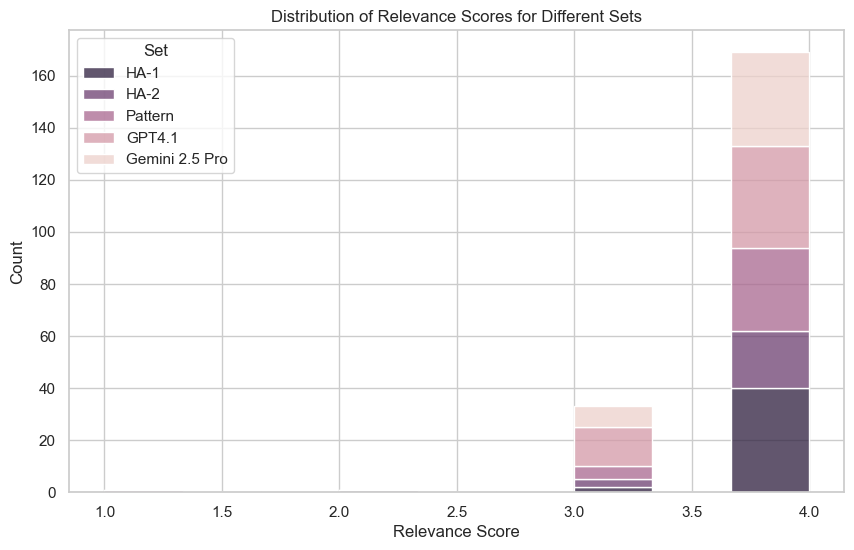

/var/folders/q6/phq9pwd56q78175j_yvjz8pc0000gn/T/ipykernel_71413/3009945488.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["set_name"] = filtered_df["set"].map(SET_MAPPING)


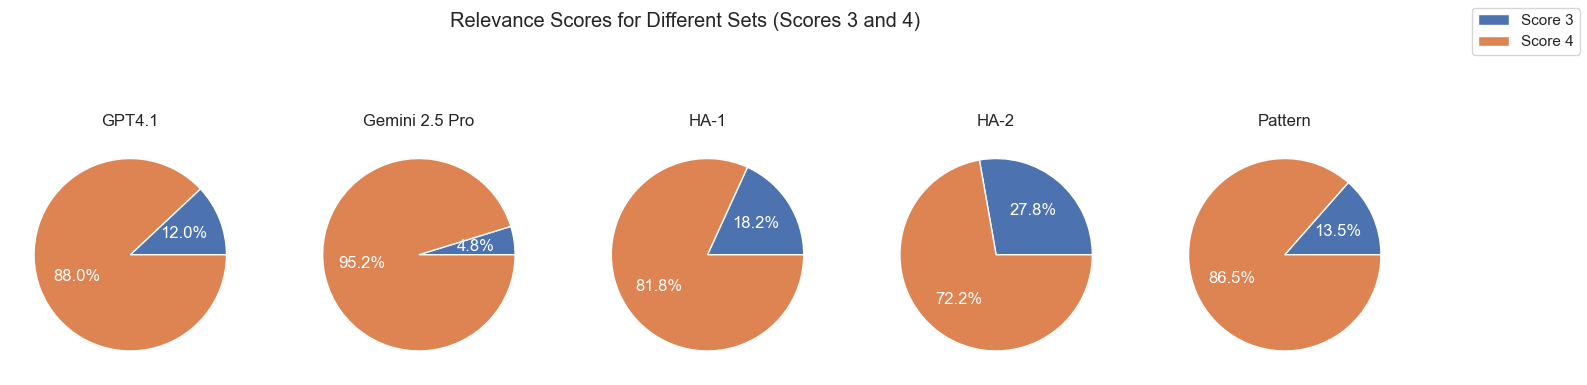

In [47]:
from config import SET_MAPPING
# the set mapping is a dict that maps the set numbers to their corresponding names

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style="whitegrid")
sns.histplot(data=merged_df, x="relevance_ge25p_score", hue="set", multiple="stack", ax=ax) 
plt.title("Distribution of Relevance Scores for Different Sets")
plt.xlabel("Relevance Score")
plt.ylabel("Count")
plt.legend(title="Set", labels=[SET_MAPPING[i] for i in merged_df["set"].unique()])
plt.show()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Use a pie chart to visualize the distribution of relevance scores per set:
# only doing it for scores 4 and 3 (since we dont have any 2s or 1s)
filtered_df = merged_df[merged_df["relevance_ge25p_score"].isin([3, 4])]
# Create a new column for the set names
filtered_df["set_name"] = filtered_df["set"].map(SET_MAPPING)
# Group the filtered_df by set_name and relevance_ge25p_score
grouped_df = filtered_df.groupby(["set_name", "relevance_ge25p_score"]).size().reset_index(name="count")

# Create a subplot for the pie charts
fig, axes = plt.subplots(1, len(grouped_df["set_name"].unique()),
                         figsize=(18, 5), subplot_kw=dict(aspect="equal"))

# Generate pie charts for each set
for ax, (set_name, group) in zip(axes, grouped_df.groupby("set_name")):
    wedges, texts, autotexts = ax.pie(
        group["count"], labels=group["relevance_ge25p_score"],
        autopct='%1.1f%%', textprops=dict(color="w")
    )
    ax.set_title(f"{set_name}")

# Add a single legend for all subplots
fig.legend(wedges, [f"Score {score}" for score
                    in group["relevance_ge25p_score"].unique()], loc="upper right")
plt.suptitle("Relevance Scores for Different Sets (Scores 3 and 4)")
plt.show()
